# ĐỒ ÁN CUỐI KỲ - NHẬP MÔN KHOA HỌC DỮ LIỆU
STT nhóm: 17

Thành viên:
- 18120066 - Bùi Đoàn Hữu Nhân
- 18120097 - Đinh Hữu Phúc Trung

##  Đề tài: Dự đoán giá xe ô tô

---

# II - Tiền xử lý và mô hình hóa
Trong file notebook này ta sẽ thực hiện tiền xử lý và mô hình hóa dữ liệu đã được thu thập sẵn như đã trình bày trong file `DACK-ThuThapDuLieu.ipynb`

&#9889; **Lưu ý:** Thời gian chạy toàn bộ file notebook này dao động từ 25-30 phút.

---

## Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
set_config(display='diagram')

In [2]:
# Để tính thời gian chạy toàn bộ file notebook này
a_start = datetime.datetime.now()

---

## Khám phá dữ liệu (đủ để đặt câu hỏi)

In [3]:
data_df = pd.read_csv('cars_data.csv', index_col=0) # Cho cột index là cột 0
data_df.head()

,Name,Brand,Price,Body,Transmission,Number Of Seats,Segment,Introduction,Drive,Drive System,...,Fuel System,Valve Actuation,Turbo,Fuel Tank,Top Speed,Energy Label,Front Stabilizer,Rear Stabilizer,Num_doors,Dt_Transmission
0,HYUNDAI I20 1 2 MPI I MOTION,HYUNDAI,17147.0,hatchback,5.0,5,b,2020,front,fuel engine,...,direct injection,dohc,no,40.0,173.0,b,yes,no,5,manual transmission
1,MERCEDES BENZ S 450 4MATIC,MERCEDES,134188.0,sedan,9.0,5,f,2020,front+rear,fuel engine,...,direct injection,dohc,yes,76.0,250.0,b,yes,yes,4,automatic
2,OPEL MOKKA 1 2 TURBO 100HP EDITION,OPEL,25400.0,suv/crossover,6.0,5,l,2020,front,fuel engine,...,direct injection,dohc,yes,44.0,188.0,b,yes,no,5,manual transmission
3,JAGUAR XF P250 S,JAGUAR,67805.0,sedan,8.0,5,e,2020,rear,fuel engine,...,direct injection,dohc,yes,74.0,250.0,c,yes,yes,4,automatic
4,JAGUAR XF SPORTBRAKE P250 S,JAGUAR,73805.0,station wagon,8.0,5,e,2020,rear,fuel engine,...,direct injection,dohc,yes,74.0,241.0,d,yes,yes,5,automatic


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [4]:
data_df.shape

(4529, 24)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa thông tin của một xe ôtô, và không có vấn đề các dòng có ý nghĩa khác nhau.

### Dữ liệu có các dòng bị lặp không?

In [5]:
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

Ý nghĩa của mỗi cột như sau:

    Name                  Tên xe
    Brand                 Hãng xe
    Price                 Giá xe
    Body                  Loại thân xe
    Transmission          Số cấp của hộp số
    Number Of Seats       Số chỗ ngồi
    Segment               Loại kích cỡ xe
    Introduction          Năm sản xuất
    Drive                 Hệ thống dẫn động
    Drive System          Loại động cơ
    Fuel                  Loại nhiên liệu
    Cylinder Capacity     Dung tích xilanh
    Max Power Hp          Công suất tối đa đơn vị là mã lực
    Max Torque            Momen xoắn cực đại
    Fuel System           Hệ thống nhiên liệu
    Valve Actuation       Kiểu kích hoạt van
    Turbo                 Bộ tăng áp
    Fuel Tank             Dung tích bình nhiên liệu
    Top Speed             Tốc độ tối đa
    Energy Label          Nhãn năng lượng
    Front Stabilizer      Bộ ổn định phía trước
    Rear Stabilizer       Bộ ổn định phía sau
    Num_doors             Số cửa
    Dt_Transmission       Loại hộp số

---

## Đưa ra câu hỏi cần trả lời

**Câu hỏi:**

*Output - giá ôtô -* được tính từ *input - các đặc trưng, bộ phận của ôtô -* theo công thức nào?

**Lợi ích:**

Việc tìm ra câu trả lời cho câu hỏi này sẽ có lợi ích là:
- Về phía người bán hoặc nhà phân phối: giúp họ định giá được xe ôtô dựa vào cấu tạo của xe.
- Về phía khách hàng (người mua): giúp người mua nắm được giá xe ôtô đúng với chất lượng thực sự của nó để tránh việc mua một sản phẩm với giá không phù hợp với chất lượng.

---

## Khám phá dữ liệu (để biết cách tách các tập)

In [6]:
# Cột output hiện có kiểu dữ liệu gì?
data_df['Price'].dtype

dtype('float64')

In [7]:
# Cột output có giá trị thiếu không?
data_df['Price'].isna().sum()

0

Như vậy là không có vấn đề gì cần xử lí ở đây cả.

---

## Tiền xử lý (tách các tập)

Bây giờ ta sẽ thực hiện bước tiền xử lý là tách tập validation và tập kiểm tra ra (theo tỉ lệ 60-20-20).

In [8]:
# Tách X và y
y_sr = data_df['Price']
X_df = data_df.drop(['Price'], axis=1)

In [9]:
# Tách tập kiểm tra
X_df, test_X_df, y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)

In [10]:
# Tách tập validation
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.25, random_state=0)

In [11]:
train_X_df.shape

(2717, 23)

In [12]:
train_y_sr.shape

(2717,)

In [13]:
val_X_df.shape

(906, 23)

In [14]:
val_y_sr.shape

(906,)

In [15]:
test_X_df.shape

(906, 23)

In [16]:
test_y_sr.shape

(906,)

In [17]:
train_X_df.head().index

Int64Index([3915, 3057, 3708, 1542, 1573], dtype='int64')

---

## Khám phá dữ liệu (tập huấn luyện)

Sau khi đã tách ra các tập thì ta có thể thoải mái khám phá trên tập huấn luyện mà không lo sẽ làm kết quả trên tập validation và tập kiểm tra bị mất đi sự khách quan.

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [18]:
train_X_df.dtypes

Name                  object
Brand                 object
Body                  object
Transmission         float64
Number Of Seats        int64
Segment               object
Introduction           int64
Drive                 object
Drive System          object
Fuel                  object
Cylinder Capacity    float64
Max Power Hp         float64
Max Torque           float64
Fuel System           object
Valve Actuation       object
Turbo                 object
Fuel Tank            float64
Top Speed            float64
Energy Label          object
Front Stabilizer      object
Rear Stabilizer       object
Num_doors              int64
Dt_Transmission       object
dtype: object

Có vẻ các cột đều có kiểu dữ liệu phù hợp. 

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [19]:
train_X_df.dtypes[train_X_df.dtypes != object]

Transmission         float64
Number Of Seats        int64
Introduction           int64
Cylinder Capacity    float64
Max Power Hp         float64
Max Torque           float64
Fuel Tank            float64
Top Speed            float64
Num_doors              int64
dtype: object

In [20]:
num_cols = ["Transmission", "Number Of Seats", "Introduction", "Cylinder Capacity", 
           "Max Power Hp", "Max Torque", "Fuel Tank", "Top Speed", "Num_doors"]
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Transmission,Number Of Seats,Introduction,Cylinder Capacity,Max Power Hp,Max Torque,Fuel Tank,Top Speed,Num_doors
missing_ratio,1.0,0.0,0.0,0.3,0.4,0.4,0.3,1.3,0.0
min,0.0,0.0,1969.0,2.0,29.0,38.0,22.0,110.0,2.0
lower_quartile,5.0,5.0,1994.0,2.0,80.0,121.0,50.0,163.0,3.0
median,5.0,5.0,2003.0,4.0,110.0,167.0,60.0,180.0,4.0
upper_quartile,6.0,5.0,2012.0,4.0,160.0,250.0,70.0,206.0,5.0
max,9.0,9.0,2021.0,5.0,1001.0,1250.0,121.0,407.0,5.0


### Với mỗi cột input có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [21]:
pd.set_option('display.max_colwidth', 200) # Để nhìn rõ hơn
cat_cols = list(set(train_X_df.columns) - set(num_cols))
df = train_X_df[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,Brand,Dt_Transmission,Fuel System,Body,Segment,Energy Label,Turbo,Fuel,Name,Drive System,Drive,Rear Stabilizer,Front Stabilizer,Valve Actuation
missing_ratio,0,0,0,0,13.1,32.5,0,0,0,0,0,0,0,0
num_values,83,5,8,11,14,7,3,4,2307,2,3,2,2,3
value_ratios,"{'TOYOTA': 5.8, 'AUDI': 5.6, 'OPEL': 5.0, 'FORD': 4.9, 'MERCEDES': 4.6, 'RENAULT': 4.5, 'VOLKSWAGEN': 4.3, 'NISSAN': 4.0, 'MAZDA': 3.6, 'BMW': 3.3, 'PEUGEOT': 3.2, 'CITROEN': 2.9, 'VOLVO': 2.8, 'H...","{'manual transmission': 83.7, 'automatic': 12.3, 'automatic with double clutch': 2.7, 'oze automatic': 1.0, 'semi-automatic': 0.3}","{'multipoint injection': 54.8, 'direct injection': 19.7, 'carburettor': 14.9, 'common rail': 5.0, 'singplepoint injection': 4.5, 'indirect injection': 0.4, 'injection': 0.4, 'multijet': 0.2}","{' hatchback': 25.9, ' sedan': 18.8, ' suv/crossover': 12.9, ' station wagon': 12.7, ' coupé': 9.6, ' convertible': 7.7, ' mpv': 7.1, ' van': 2.8, ' bus': 1.1, ' pick-up': 0.8, ' double cabin': 0.4}","{'c': 19.6, 'd': 15.9, 'b': 9.9, 'g': 9.7, 'e': 8.3, 'm': 7.6, 'l': 7.0, 'j': 6.0, 'a': 4.8, 'n': 4.1, 'h': 3.1, 'k': 1.8, 'f': 1.5, 'i': 0.6}","{'g': 57.0, 'f': 9.3, 'e': 8.8, 'c': 8.0, 'd': 7.8, 'b': 6.7, 'a': 2.3}","{'no': 74.6, 'yes': 25.0, 'mechanical': 0.5}","{'gasoline': 94.1, 'diesel': 5.8, 'gasoline / bio ethanol': 0.1, 'lpg / gasoline': 0.0}","{'MAZDA 323 1 3 LX': 0.2, 'PORSCHE 911 CARRERA CABRIOLET': 0.2, 'BMW 116I': 0.2, 'BMW 520I TOURING': 0.2, 'BMW 520I': 0.2, 'PORSCHE 911 CARRERA COUPE': 0.2, 'TOYOTA COROLLA 1 4 16V VVT I': 0.1, 'B...","{'fuel engine': 98.8, 'hybrid': 1.2}","{'front': 64.4, 'rear': 21.5, 'front+rear': 14.1}","{'yes': 70.4, 'no': 29.6}","{'yes': 89.1, 'no': 10.9}","{'dohc': 61.4, 'ohc': 33.9, 'ohv': 4.7}"


---

## Tiền xử lý (tập huấn luyện)

Đầu tiên, ta sẽ xử lý một số cột như sau: 
- Bỏ cột "Segment" vì có nhiều giá trị thiếu, nhiều giá trị khác nhau và phần nào cột "Body" cũng đã chứa thông tin loại kích cỡ ở cột này.
- Bỏ cột "Energy Label" vì có quá nhiều giá trị thiếu.
- Bỏ cột "Name" vì có rất nhiều giá trị khác nhau, thêm vào đó cột này được suy diễn từ những cột khác.
- Ở cột "Fuel System" và "Body" ta sẽ lấy `num_top_fuel_sys` và `num_top_body` các giá trị xuất hiện nhiều nhất.

**Ngoại lệ:** Cột "Brand" có nhiều giá trị khác nhau, nhưng các giá trị này có tỉ lệ xuất hiện gần như là ngang nhau và cột này cần thiết trong việc tính giá của xe ôtô nên ta sẽ giữ lại.

In [22]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_fuel_sys=1, num_top_body=1):
        self.num_top_fuel_sys = num_top_fuel_sys
        self.num_top_body = num_top_body
    def fit(self, X_df, y=None):
        # Fuel System
        self.fuel_sys_counts_ = X_df['Fuel System'].value_counts()
        fuel_sys = list(self.fuel_sys_counts_.index)
        self.top_fuel_sys_ = fuel_sys[:max(1, min(self.num_top_fuel_sys, len(fuel_sys)))]
        # Body
        self.body_counts_ = X_df['Body'].value_counts()
        body = list(self.body_counts_.index)
        self.top_body_ = body[:max(1, min(self.num_top_body, len(body)))]
        return self
    def transform(self, X_df, y=None):
        new_df = X_df.copy()
        # Fuel System
        fuel_sys_list = list(new_df['Fuel System'])
        for i in range(len(fuel_sys_list)):
            if fuel_sys_list[i] not in self.top_fuel_sys_:
                fuel_sys_list[i] = 'others'
        new_df['Fuel System'] = fuel_sys_list
        # Body
        body_list = list(new_df['Body'])
        for i in range(len(body_list)):
            if body_list[i] not in self.top_body_:
                body_list[i] = 'others'
        new_df['Body'] = body_list
        new_df = new_df.drop(['Name', 'Energy Label', 'Segment'], axis=1)
        return new_df

In [23]:
col_adderdropper = ColAdderDropper(num_top_fuel_sys=3, num_top_body=2)
col_adderdropper.fit(train_X_df)
fewer_cols_train_X_df = col_adderdropper.transform(train_X_df)
fewer_cols_train_X_df.head()

,Brand,Body,Transmission,Number Of Seats,Introduction,Drive,Drive System,Fuel,Cylinder Capacity,Max Power Hp,Max Torque,Fuel System,Valve Actuation,Turbo,Fuel Tank,Top Speed,Front Stabilizer,Rear Stabilizer,Num_doors,Dt_Transmission
3915,DAIHATSU,others,5.0,5,1997,front+rear,fuel engine,gasoline,4.0,83.0,105.0,multipoint injection,ohc,no,46.0,145.0,yes,no,5,manual transmission
3057,MERCEDES,others,6.0,5,2001,rear,fuel engine,gasoline,4.0,129.0,185.0,multipoint injection,dohc,no,62.0,206.0,yes,yes,5,manual transmission
3708,HONDA,others,5.0,5,2003,front,fuel engine,gasoline,4.0,155.0,190.0,multipoint injection,dohc,no,65.0,205.0,yes,yes,5,manual transmission
1542,DATSUN,sedan,5.0,0,1979,rear,fuel engine,gasoline,2.0,113.0,175.0,carburettor,ohc,no,60.0,170.0,yes,no,4,manual transmission
1573,AUDI,others,6.0,2,2012,front+rear,fuel engine,gasoline,4.0,430.0,430.0,direct injection,dohc,no,80.0,300.0,yes,yes,2,manual transmission


Các bước tiền xử lý tiếp theo như sau:
- Với các cột dạng số, ta sẽ điền giá trị thiếu bằng giá trị mean của cột <font color=gray>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột dạng số trong tập huấn luyện, ta đều cần tính mean, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới. 
- Với các cột không phải dạng số và không có thứ tự:
    - Ta sẽ điền giá trị thiếu bằng giá trị mode (giá trị xuất hiện nhiều nhất) của cột <font color=gray>(gợi ý: dùng `SimpleImputer` trong Sklearn)</font>. Với *tất cả* các cột không có dạng số và không có thứ tự, ta đều cần tính mode, vì ta không biết được cột nào sẽ bị thiếu giá trị khi dự đoán với các véc-tơ input mới.
    - Sau đó, ta sẽ chuyển sang dạng số bằng phương pháp mã hóa one-hot <font color=gray>(gợi ý: dùng `OneHotEncoder` trong Sklearn, để ý tham số `handle_unknown` vì khi dự đoán với các véc-tơ input mới ...)</font>.

- Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng cách trừ đi mean và chia cho độ lệch chuẩn của cột để giúp cho các thuật toán cực tiểu hóa như Gradient Descent, LBFGS, ... hội tụ nhanh hơn <font color=gray>(gợi ý: dùng `StandardScaler` trong Sklearn)</font>.

Ở bước này ta sẽ tạo ra một pipeline, đặt tên là `preprocess_pipeline`, bao gồm: các bước cài ở class `ColAdderDropper`, và tất cả các bước ở đây. Sau khi tạo ra được pipeline này rồi, bạn sẽ gọi phương thức `fit_transform` với đầu vào là `train_X_df` để tính các giá trị từ tập huấn luyện và đồng thời tiền xử lý `train_X_df`; kết quả trả về sẽ là `train_X_df` sau khi đã tiền xử lý, là một mảng Numpy, bạn đặt tên là `preprocessed_train_X`.

In [24]:
# Tạo pipepline xử lí
nume_cols = ['Transmission', 'Number Of Seats', 'Introduction', 'Cylinder Capacity', 'Max Power Hp', 
            'Max Torque', 'Fuel Tank', 'Top Speed', 'Num_doors']
unorder_cate_cols = list(set(fewer_cols_train_X_df.columns) - set(nume_cols))
# Column transformer
col_trans = make_column_transformer((SimpleImputer(missing_values=np.nan, strategy='mean'), nume_cols), 
                                    (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='most_frequent'), 
                                                   OneHotEncoder(handle_unknown="ignore")), unorder_cate_cols))
# Preprocess pipeline
preprocess_pipeline = make_pipeline(ColAdderDropper(num_top_fuel_sys=3, num_top_body=2), 
                                    col_trans, StandardScaler(with_mean=False))

preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [25]:
preprocess_pipeline

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(num_top_body=2, num_top_fuel_sys=3)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['Transmission',
                                                   'Number Of Seats',
                                                   'Introduction',
                                                   'Cylinder Capacity',
                                                   'Max Power Hp', 'Max Torque',
                                                   'Fuel Tank', 'Top Speed',
                                                   'Num_doors']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Dt_Transmission',
                                                   'Fuel System', 'Body',
                                                   'Turbo', 'Fuel',
                                                   'Drive System', 'Drive',
                                                   'Rear Stabilizer',
                                                   'Front Stabilizer',
                                                   'Valve Actuation'])])),
                ('standardscaler', StandardScaler(with_mean=False))])

## Tiền xử lý (tập validation)

Một khi đã có `preprocess_pipeline` với các giá trị đã được tính từ tập huấn luyện, ta có thể dễ dàng dùng phương thức `transform` để tiền xử lý cho các véc-tơ input mới trong tập validation và tập kiểm tra. Dưới đây, ta sẽ làm như vậy để tiền xử lý cho `val_X_df` và lưu kết quả vào `preprocessed_val_X`.

In [26]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)

---

## Tiền xử lý + mô hình hóa

### Tìm mô hình tốt nhất 

Ta sẽ sử dụng mô hình Neural Net để phân lớp.  Tại đây ta tạo ra một pipeline từ đầu đến cuối bao gồm: các bước tiền xử lý ở trên + Neural Net (với các siêu tham số `hidden_layer_sizes=(30), activation='relu', solver='adam', random_state=0, max_iter=5000`). Đặt tên cho pipeline này là `full_pipeline`. 

**Ý nghĩa của siêu tham số trên:**
    
`activation='relu'`: hàm đơn vị tuyến tính được chỉnh lưu, trả về f(x) = max(0, x).

`solver='adam'`: do dữ liệu rất nhiều và không có hệ thống nên sử dụng thuật toán 'adam' rất hiệu quả (theo scikit-learn)

`max_iter=5000`: để cho thuật toán được hội tụ, nếu set quá thấp sẽ không đủ lần lặp để hội tụ.

Sau khi đã có được pipeline từ đầu đến cuối này, ta sẽ thử nghiệm:
- Siêu tham số `alpha` (mức độ L2 regularization hay weight decay) của `MLPRegressor` với 3 giá trị khác nhau: 0.1, 1, 100.
- Siêu tham số `num_top_fuel_sys` của `ColAdderDropper` (ở bước tiền xử lý) với 3 giá trị khác nhau: 2, 3, 4.
- Siêu tham số `num_top_body` của `ColAdderDropper` (ở bước tiền xử lý) với 3 giá trị khác nhau: 3, 5, 6.

Để gán lại giá trị `alpha` `num_top_fuel_sys` và `num_top_body` cho `full_pipeline`, dùng phương thức `set_params`: 

`full_pipeline.set_params(coladderdropper__num_top_fuel_sys=..., coladderdropper__num_top_body=..., mlpregressor__alpha=...)`

Trong câu lệnh ở trên, `coladderdropper` và `mlpregressor` là tên của 2 bước trong `full_pipeline`.  

Như vậy, tổng cộng ta sẽ thử nghiệm $3\times3\times3 = 27$ mô hình khác nhau, với mỗi mô hình ta sẽ: huấn luyện trên tập huấn luyện, tính độ lỗi trên tập validation rồi `append` độ lỗi vào list `val_errs` (để dễ nhìn, ta sẽ tính độ lỗi theo đơn vị %, nghĩa là có giá trị từ 0-100 chứ không phải từ 0-1). Tiếp theo lưu lại độ lỗi nhỏ nhất trên tập validation và giá trị `alpha` `num_top_fuel_sys` và `num_top_body` tương ứng lần lượt vào biến `best_val_err`, `best_alpha`, `best_num_top_fuel_sys`, `best_num_top_body`.

In [27]:
# Tính độ đo r^2 trên tập huấn luyện
def compute_mse(y, preds):
    return ((y - preds) ** 2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)
baseline_preds = train_y_sr.mean()
#compute_rr(test_y_sr, full_pipeline.predict(test_X_df), baseline_preds)

In [28]:
# Tạo full pipeline
# Train mô hình và chọn siêu tham số
# Tạo full pipeline
nume_cols = ['Number Of Seats', 'Introduction', 'Cylinder Capacity', 'Max Power Hp', 'Max Torque', 'Fuel Tank', 'Top Speed', 'Combined Consumption']
unorder_cate_cols = list(set(train_X_df.columns) - set(nume_cols))
# YOUR CODE HERE
full_pipeline = make_pipeline(ColAdderDropper(num_top_fuel_sys=3, num_top_body=2),
                              col_trans, StandardScaler(with_mean=False), 
                              MLPRegressor(hidden_layer_sizes=(30), activation='relu', solver='adam', random_state=0, max_iter=5000))

# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 100]
num_top_fuel_sys_s = [2, 3, 4]
num_top_body_s = [2, 4, 6]
best_val_err = float('inf'); best_alpha = None 
best_num_top_body = None; best_num_top_fuel_sys = None
for num_top_fuel_sys in num_top_fuel_sys_s:
    for num_top_body in num_top_body_s:
        for alpha in alphas:
            # YOUR CODE HERE
            full_pipeline.set_params(coladderdropper__num_top_fuel_sys=num_top_fuel_sys, 
                                     coladderdropper__num_top_body=num_top_body, mlpregressor__alpha=alpha)
            full_pipeline.fit(train_X_df, train_y_sr)

            train_err = (1 - full_pipeline.score(train_X_df, train_y_sr))*100
            train_errs.append(train_err)
            #val_err = (1 - full_pipeline.score(val_X_df, val_y_sr))*100
            val_err = (1 - compute_rr(val_y_sr, full_pipeline.predict(val_X_df), baseline_preds))*100
            val_errs.append(val_err)
            if val_err < best_val_err:
                best_num_top_fuel_sys = num_top_fuel_sys
                best_num_top_body = num_top_body
                best_val_err = val_err
                best_alpha = alpha
'Finish!'

D:\Downloads\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Downloads\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Downloads\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Downloads\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Downloads\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perce

'Finish!'

*Lỗi warning ở trên em đã thử với số vòng lặp lớn hơn rất nhiều nhưng vẫn không khắc phục được.*

In [29]:
full_pipeline

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(num_top_body=6, num_top_fuel_sys=4)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['Transmission',
                                                   'Number Of Seats',
                                                   'Introduction',
                                                   'Cylinder Capacity',
                                                   'Max Power Hp', 'Max Torque',
                                                   'Fuel Tank', 'Top Speed',
                                                   'Num_doors']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   Simpl...nt')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Dt_Transmission',
                                                   'Fuel System', 'Body',
                                                   'Turbo', 'Fuel',
                                                   'Drive System', 'Drive',
                                                   'Rear Stabilizer',
                                                   'Front Stabilizer',
                                                   'Valve Actuation'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('mlpregressor',
                 MLPRegressor(alpha=100, hidden_layer_sizes=30, max_iter=5000,
                              random_state=0))])

In [35]:
print(best_alpha)
print(best_num_top_body)
print(best_num_top_fuel_sys)

100
6
4


Cuối cùng, ta sẽ huấn luyện lại `full_pipeline` trên `X_df` và `y_sr` (tập huấn luyện + tập validation) với `best_alpha`, `best_num_top_fuel_sys` và `best_num_top_body` tìm được ở trên để ra được mô hình cụ thể cuối cùng.

In [31]:
full_pipeline.set_params(coladderdropper__num_top_fuel_sys=best_num_top_fuel_sys, 
                         coladderdropper__num_top_body=best_num_top_body, mlpregressor__alpha=best_alpha)
full_pipeline.fit(X_df, y_sr)

Pipeline(steps=[('coladderdropper',
                 ColAdderDropper(num_top_body=6, num_top_fuel_sys=4)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(),
                                                  ['Transmission',
                                                   'Number Of Seats',
                                                   'Introduction',
                                                   'Cylinder Capacity',
                                                   'Max Power Hp', 'Max Torque',
                                                   'Fuel Tank', 'Top Speed',
                                                   'Num_doors']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   Simpl...nt')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Dt_Transmission',
                                                   'Fuel System', 'Body',
                                                   'Turbo', 'Fuel',
                                                   'Drive System', 'Drive',
                                                   'Rear Stabilizer',
                                                   'Front Stabilizer',
                                                   'Valve Actuation'])])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('mlpregressor',
                 MLPRegressor(alpha=100, hidden_layer_sizes=30, max_iter=5000,
                              random_state=0))])

---

## Đánh giá mô hình tìm được 

In [32]:
# Độ chính xác của mô hình trên tập test
compute_rr(test_y_sr, full_pipeline.predict(test_X_df), baseline_preds)*100

88.04765798933552

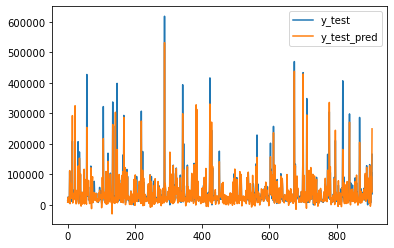

In [33]:
# Trực quan hóa kết quả mô hình ứng với tập test
plt.plot(test_y_sr.reset_index(drop=True))
plt.plot(full_pipeline.predict(test_X_df))
plt.legend(['y_test','y_test_pred'])

In [34]:
# Thời gian chạy toàn bộ file notebook
print(datetime.datetime.now() - a_start)

0:25:46.921837


---

## Nhìn lại quá trình làm đồ án
- Đã gặp những khó khăn gì?
    - Khó khăn trong việc thu thập dữ liệu: những trang web có thông tin chi tiết cụ thể rõ ràng về xe ôtô thì đa số đều không cho crawl dữ liệu nên việc tìm và chọn một trang web ưng ý khá khó. Và khi thu thập được thông tin của xe từ trang web đã chọn thì việc xử lý dữ liệu thô này khá tốn thời gian.
    - Khó khăn trong việc mô hình hóa dữ liệu: vì thời gian train của mô hình tương đối lâu nên việc chạy và tìm các siêu tham số tốt nhất cho mô hình tiêu tốn khá nhiều thời gian.
- Có học được gì hữu ích?
    - Rút ra được để có kết quả mô hình tốt thì cần phải tìm hiểu chủ đề thật kĩ để chọn ra các thông tin cần thiết cho câu trả lời.
    - Ngoài việc trao dồi thêm kiến thức về môn học thì còn biết thêm về kiến thức thuộc chủ đề của nhóm (kiến thức về xe ôtô).
- Nếu có thêm thời gian thì sẽ làm gì?
    - Cải tiến mô hình để tăng độ chính xác và ổn định độ chính xác trên các tập dữ liệu khác nhau.
    - Cải thiện thời gian train mô hình.
    - Thử nghiệm nhiều mô hình hơn để tìm ra mô hình tốt nhất.

---

## Tài liệu tham khảo

- File `BT03-TienXuLy_MoHinhHoa.ipynb`

- Các file `03-Demo.ipynb`, `04-Demo.ipynb`, `07-Demo.ipynb`

- Trang [scikit-learn 0.24.0 documentation](https://scikit-learn.org/stable/index.html)

- Trang [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/index.html)

- Trang [python 3.9.1 documentation](https://docs.python.org/3/)

- Trang [stackoverflow](https://stackoverflow.com/)

- Trang [webdriver-chromium](https://docs.microsoft.com/en-us/microsoft-edge/webdriver-chromium/?tabs=c-sharp)

---